In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
# Define file paths
ratings_file = 'ratings.dat'
users_file = 'users.dat'
movies_file = 'movies.dat'

# Load datasets
ratings = pd.read_csv(
    ratings_file,
    sep='::',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
    engine='python'
)

users = pd.read_csv(
    users_file,
    sep='::',
    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],
    engine='python'
)

movies = pd.read_csv(
    movies_file,
    sep='::',
    names=['MovieID', 'Title', 'Genres'],
    engine='python',
    encoding='latin-1'
)


In [4]:
# Split genres and perform one-hot encoding
movies['Genres'] = movies['Genres'].str.split('|')
genres_list = list(set([genre for sublist in movies['Genres'] for genre in sublist]))
genres_encoded = movies['Genres'].apply(lambda x: pd.Series([1 if genre in x else 0 for genre in genres_list], index=genres_list))
movies = pd.concat([movies, genres_encoded], axis=1)


In [5]:
# Merge ratings with movies and users
data = ratings.merge(movies, on='MovieID').merge(users, on='UserID')


In [6]:
# Create a pivot table
user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)

# Convert to numpy array for SVD
R = user_item_matrix.values
user_ids = user_item_matrix.index.tolist()
movie_ids = user_item_matrix.columns.tolist()


In [7]:
# Normalize the ratings (mean centering)
R_mean = np.mean(R, axis=1, keepdims=True)
R_demeaned = R - R_mean

# Perform SVD
U, sigma, Vt = svds(R_demeaned, k=100)
sigma = np.diag(sigma)

# Reconstruct the approximated ratings matrix
cf_predictions = np.dot(np.dot(U, sigma), Vt) + R_mean

# Convert to DataFrame
cf_preds_df = pd.DataFrame(cf_predictions, index=user_ids, columns=movie_ids)


In [8]:
# Create item profiles (movie features)
item_profiles = movies.set_index('MovieID')[genres_list]

# Compute item-item similarity matrix
item_similarity = cosine_similarity(item_profiles)
item_similarity_df = pd.DataFrame(item_similarity, index=item_profiles.index, columns=item_profiles.index)


In [9]:
def predict_ratings_content(user_id):
    user_ratings = user_item_matrix.loc[user_id]
    user_unrated_movies = user_ratings[user_ratings == 0].index.tolist()
    user_rated_movies = user_ratings[user_ratings > 0].index.tolist()
    
    # Get the similarity scores between unrated and rated movies
    sim_scores = item_similarity_df.loc[user_unrated_movies, user_rated_movies].values  # Convert to NumPy array
    
    # Get the user's ratings for rated movies
    user_ratings_rated = user_ratings[user_rated_movies].values  # Convert to NumPy array
    
    # Calculate the numerator and denominator
    numerator = sim_scores.dot(user_ratings_rated)
    denominator = np.abs(sim_scores).sum(axis=1)
    
    # Avoid division by zero
    denominator[denominator == 0] = 1e-10
    
    # Compute predicted ratings
    pred_ratings = numerator / denominator
    
    # Create a Series with the predicted ratings
    predictions = pd.Series(pred_ratings, index=user_unrated_movies)
    return predictions

content_preds = {}
for user_id in user_ids:
    content_preds[user_id] = predict_ratings_content(user_id)

In [10]:
def hybrid_predict(user_id, alpha=0.3):
    # Get collaborative and content-based predictions
    cf_user_pred = cf_preds_df.loc[user_id]
    content_user_pred = content_preds[user_id]
    
    # Align indices and fill missing values
    cf_user_pred = cf_user_pred.reindex(movie_ids).fillna(0)
    content_user_pred = content_user_pred.reindex(movie_ids).fillna(0)
    
    # Combine predictions
    hybrid_pred = alpha * cf_user_pred + (1 - alpha) * content_user_pred
    return hybrid_pred


In [11]:
# Split ratings data
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Recreate user-item matrix for training data
train_user_item_matrix = train_data.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)


In [12]:
# Create R matrix for training data
R_train = train_user_item_matrix.values
R_train_mean = np.mean(R_train, axis=1, keepdims=True)
R_train_demeaned = R_train - R_train_mean

# Perform SVD
U_train, sigma_train, Vt_train = svds(R_train_demeaned, k=50)
sigma_train = np.diag(sigma_train)

# Predict ratings
cf_predictions_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + R_train_mean
cf_preds_df_train = pd.DataFrame(cf_predictions_train, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)


In [13]:
def predict_ratings_content_train(user_id):
    user_ratings = train_user_item_matrix.loc[user_id]
    user_unrated_movies = user_ratings[user_ratings == 0].index.tolist()
    user_rated_movies = user_ratings[user_ratings > 0].index.tolist()
    
    if not user_rated_movies:
        # Cold-start user
        return pd.Series(0, index=user_unrated_movies)
    
    # Get similarity scores as a NumPy array
    sim_scores = item_similarity_df.loc[user_unrated_movies, user_rated_movies].values  # Shape: (num_unrated_movies, num_rated_movies)
    user_ratings_rated = user_ratings[user_rated_movies].values  # Shape: (num_rated_movies,)
    
    # Compute numerator and denominator
    numerator = np.dot(sim_scores, user_ratings_rated)  # Shape: (num_unrated_movies,)
    denominator = np.sum(np.abs(sim_scores), axis=1)  # Shape: (num_unrated_movies,)
    
    # Avoid division by zero
    denominator[denominator == 0] = 1e-10
    
    # Compute predicted ratings
    pred_ratings = numerator / denominator  # Shape: (num_unrated_movies,)
    
    # Create a Series with predicted ratings
    predictions = pd.Series(pred_ratings, index=user_unrated_movies)
    return predictions



In [16]:
#content_preds_train = {}
#for user_id in train_user_item_matrix.index:
    #content_preds_train[user_id] = predict_ratings_content_train(user_id)

# Prepare test data
test_user_item_matrix = test_data.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)
test_user_ids = test_user_item_matrix.index.tolist()

def compute_rmse(predictions, ground_truth):
    # Align indices
    predictions = predictions.reindex(index=ground_truth.index, columns=ground_truth.columns).fillna(0)
    mse = mean_squared_error(ground_truth.values.flatten(), predictions.values.flatten())
    return np.sqrt(mse)

# Collaborative Filtering RMSE
cf_preds_test = cf_preds_df_train.reindex(index=test_user_item_matrix.index, columns=test_user_item_matrix.columns).fillna(0)
cf_rmse = compute_rmse(cf_preds_test, test_user_item_matrix)

# Content-Based Filtering RMSE
content_preds_test = pd.DataFrame(index=test_user_item_matrix.index, columns=test_user_item_matrix.columns)
for user_id in test_user_item_matrix.index:
    content_pred = content_preds.get(user_id, pd.Series(0, index=test_user_item_matrix.columns))
    content_preds_test.loc[user_id] = content_pred
content_preds_test = content_preds_test.fillna(0)
content_rmse = compute_rmse(content_preds_test, test_user_item_matrix)

# Hybrid Model RMSE
alpha = 0.3  # Adjust based on validation
hybrid_preds_test = alpha * cf_preds_test + (1 - alpha) * content_preds_test
hybrid_rmse = compute_rmse(hybrid_preds_test, test_user_item_matrix)

print(f'Collaborative Filtering RMSE: {cf_rmse:.4f}')
print(f'Content-Based Filtering RMSE: {content_rmse:.4f}')
print(f'Hybrid Model RMSE: {hybrid_rmse:.4f}')


C:\Users\shiva\AppData\Local\Temp\ipykernel_6444\514941469.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  content_preds_test = content_preds_test.fillna(0)


Collaborative Filtering RMSE: 0.5262
Content-Based Filtering RMSE: 3.6146
Hybrid Model RMSE: 2.5639


In [42]:
def get_top_n_recommendations(user_id, n=10):
    # Get predictions
    hybrid_pred = hybrid_predict(user_id, alpha=0.7)
    
    # Exclude movies the user has already rated
    user_rated_movies = train_data[train_data['UserID'] == user_id]['MovieID'].tolist()
    recommendations = hybrid_pred.drop(labels=user_rated_movies).sort_values(ascending=False).head(n)
    
    # Get movie titles
    recommended_movies = movies.loc[movies['MovieID'].isin(recommendations.index)][['MovieID', 'Title']]
    return recommended_movies

# Example: Get top 10 recommendations for a user
user_id = test_user_item_matrix.index[0]
recommendations = get_top_n_recommendations(user_id)
print(f'Top 10 recommendations for User {user_id}:')
print(recommendations)


Top 10 recommendations for User 1:
      MovieID                                   Title
360       364                   Lion King, The (1994)
1019     1032              Alice in Wonderland (1951)
1176     1193  One Flew Over the Cuckoo's Nest (1975)
1207     1225                          Amadeus (1984)
1262     1282                         Fantasia (1940)
2009     2078                 Jungle Book, The (1967)
2012     2081              Little Mermaid, The (1989)
2018     2087                        Peter Pan (1953)
2027     2096                  Sleeping Beauty (1959)
2647     2716                     Ghostbusters (1984)


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a range of alpha values to test
alpha_values = np.linspace(0, 1, num=11)  # Values from 0 to 1 in increments of 0.1

# Dictionary to store RMSE results
hybrid_rmse_results = {}

# Loop over alpha values
for alpha in alpha_values:
    # Generate hybrid predictions for all users in the test set
    hybrid_preds_list = []
    for user_id in test_user_item_matrix.index:
        # Get hybrid predictions
        hybrid_pred = hybrid_predict(user_id, alpha=alpha)
        
        # Align with test data
        test_ratings = test_user_item_matrix.loc[user_id]
        common_items = test_ratings[test_ratings > 0].index
        hybrid_pred = hybrid_pred.loc[common_items]
        
        # Store predictions and actual ratings
        for item_id in common_items:
            hybrid_preds_list.append({
                'UserID': user_id,
                'MovieID': item_id,
                'PredRating': hybrid_pred[item_id],
                'TrueRating': test_ratings[item_id]
            })
    
    # Create DataFrame of predictions
    hybrid_preds_df = pd.DataFrame(hybrid_preds_list)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(hybrid_preds_df['TrueRating'], hybrid_preds_df['PredRating']))
    hybrid_rmse_results[alpha] = rmse
    print(f'Alpha: {alpha:.2f}, Hybrid Model RMSE: {rmse:.4f}')


Alpha: 0.00, Hybrid Model RMSE: 3.7533
Alpha: 0.10, Hybrid Model RMSE: 3.5460
Alpha: 0.20, Hybrid Model RMSE: 3.3434
Alpha: 0.30, Hybrid Model RMSE: 3.1464
Alpha: 0.40, Hybrid Model RMSE: 2.9563
Alpha: 0.50, Hybrid Model RMSE: 2.7744
Alpha: 0.60, Hybrid Model RMSE: 2.6024
Alpha: 0.70, Hybrid Model RMSE: 2.4425
Alpha: 0.80, Hybrid Model RMSE: 2.2972
Alpha: 0.90, Hybrid Model RMSE: 2.1693
Alpha: 1.00, Hybrid Model RMSE: 2.0621


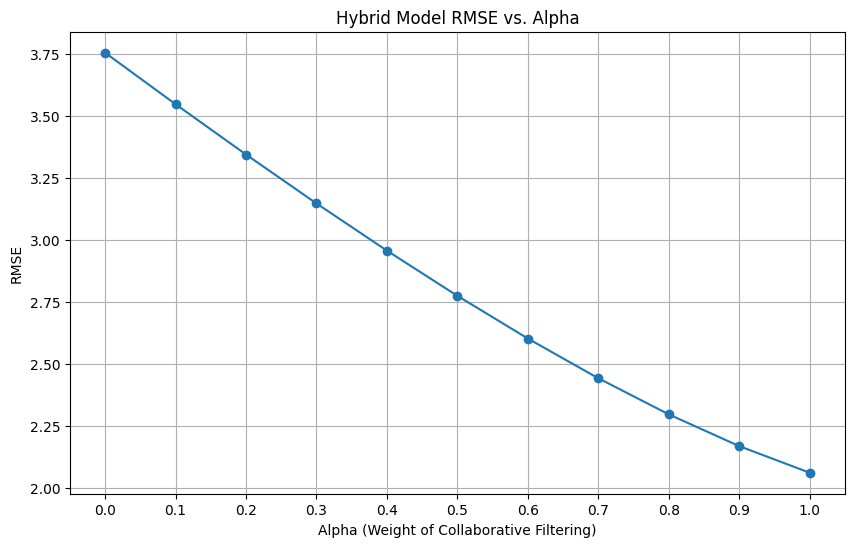

In [44]:
# Prepare data for plotting
alphas = list(hybrid_rmse_results.keys())
rmses = list(hybrid_rmse_results.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(alphas, rmses, marker='o', linestyle='-')
plt.title('Hybrid Model RMSE vs. Alpha')
plt.xlabel('Alpha (Weight of Collaborative Filtering)')
plt.ylabel('RMSE')
plt.xticks(alphas)
plt.grid(True)
plt.show()


In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'data' is a DataFrame containing your features and target variable 'Rating'
X = data.drop(['Rating'], axis=1)
y = data['Rating']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Predict on test set
y_pred = bst.predict(dtest)

# Evaluate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'XGBoost Regression RMSE: {rmse:.4f}')


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
def precision_at_k(y_true, y_pred, k):
    # y_true and y_pred are arrays of item IDs
    y_pred_top_k = y_pred[:k]
    relevant_items = set(y_true)
    recommended_items = set(y_pred_top_k)
    precision = len(recommended_items & relevant_items) / k
    return precision

def recall_at_k(y_true, y_pred, k):
    y_pred_top_k = y_pred[:k]
    relevant_items = set(y_true)
    recommended_items = set(y_pred_top_k)
    recall = len(recommended_items & relevant_items) / len(relevant_items)
    return recall

# Example for one user
user_test_data = X_test[X_test['UserID'] == user_id]
user_true_items = user_test_data[user_test_data['Rating'] >= 4]['MovieID'].tolist()  # Relevant items
user_pred_scores = bst.predict(xgb.DMatrix(user_test_data.drop(['UserID', 'MovieID'], axis=1)))
user_pred_items = user_test_data['MovieID'].tolist()

# Sort predicted items by their predicted scores
sorted_items = [item for _, item in sorted(zip(user_pred_scores, user_pred_items), reverse=True)]

# Compute Precision@K and Recall@K
k = 10
prec = precision_at_k(user_true_items, sorted_items, k)
rec = recall_at_k(user_true_items, sorted_items, k)
print(f'User {user_id} - Precision@{k}: {prec:.4f}, Recall@{k}: {rec:.4f}')


In [6]:
import pandas as pd

# Define file paths
ratings_path = 'ratings.dat'
movies_path = 'movies.dat'
users_path = 'users.dat'

# Column names for the files
ratings_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies_cols = ['MovieID', 'Title', 'Genres']
users_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

# Load the datasets
ratings = pd.read_csv(ratings_path, sep="::", names=ratings_cols, engine='python', encoding='latin-1')
movies = pd.read_csv(movies_path, sep="::", names=movies_cols, engine='python', encoding='latin-1')
users = pd.read_csv(users_path, sep="::", names=users_cols, engine='python', encoding='latin-1')

# Display data samples
print("Ratings Sample:")
print(ratings.head())

print("\nMovies Sample:")
print(movies.head())

print("\nUsers Sample:")
print(users.head())



Ratings Sample:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Movies Sample:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Users Sample:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


In [ ]:
print(f"Number of Ratings: {ratings.shape[0]}")
print(f"Number of Movies: {movies.shape[0]}")
print(f"Number of Users: {users.shape[0]}")




Number of Ratings: 1000209
Number of Movies: 3883
Number of Users: 6040
Missing values in Ratings: 0
Missing values in Movies: 0
Missing values in Users: 0


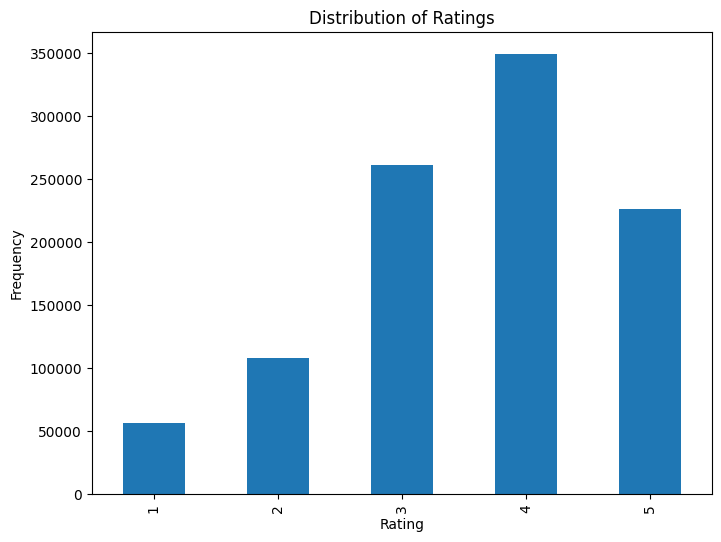

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
ratings['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [9]:
avg_ratings_per_movie = ratings.groupby('MovieID')['Rating'].mean()
print(avg_ratings_per_movie.describe())


count    3706.000000
mean        3.238892
std         0.672925
min         1.000000
25%         2.822705
50%         3.331546
75%         3.740741
max         5.000000
Name: Rating, dtype: float64


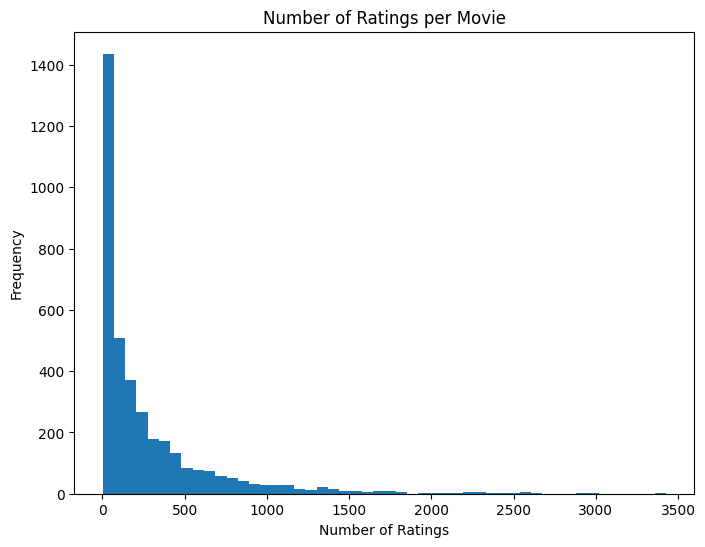

In [10]:
ratings_per_movie = ratings['MovieID'].value_counts()
plt.figure(figsize=(8, 6))
plt.hist(ratings_per_movie, bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


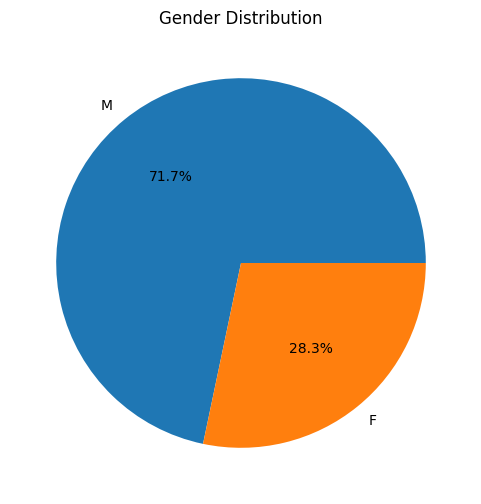

In [12]:
users['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title='Gender Distribution')
plt.ylabel('')
plt.show()


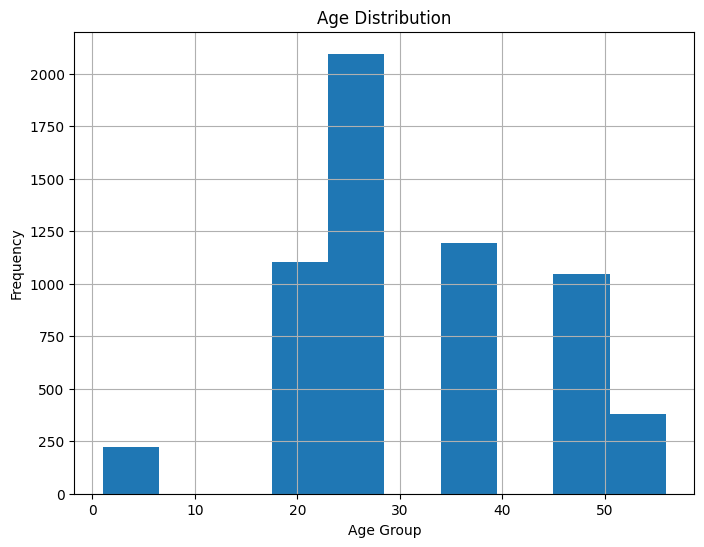

In [13]:
users['Age'].hist(bins=10, figsize=(8, 6))
plt.title('Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()


In [16]:
top_movies = ratings['MovieID'].value_counts().head(10).index
top_movie_titles = movies[movies['MovieID'].isin(top_movies)]
print(top_movie_titles)


      MovieID                                              Title  \
257       260          Star Wars: Episode IV - A New Hope (1977)   
476       480                               Jurassic Park (1993)   
585       589                  Terminator 2: Judgment Day (1991)   
589       593                   Silence of the Lambs, The (1991)   
1178     1196  Star Wars: Episode V - The Empire Strikes Back...   
1192     1210  Star Wars: Episode VI - Return of the Jedi (1983)   
1250     1270                          Back to the Future (1985)   
1959     2028                         Saving Private Ryan (1998)   
2502     2571                                 Matrix, The (1999)   
2789     2858                             American Beauty (1999)   

                                   Genres  
257       Action|Adventure|Fantasy|Sci-Fi  
476               Action|Adventure|Sci-Fi  
585                Action|Sci-Fi|Thriller  
589                        Drama|Thriller  
1178    Action|Adventure|Drama|

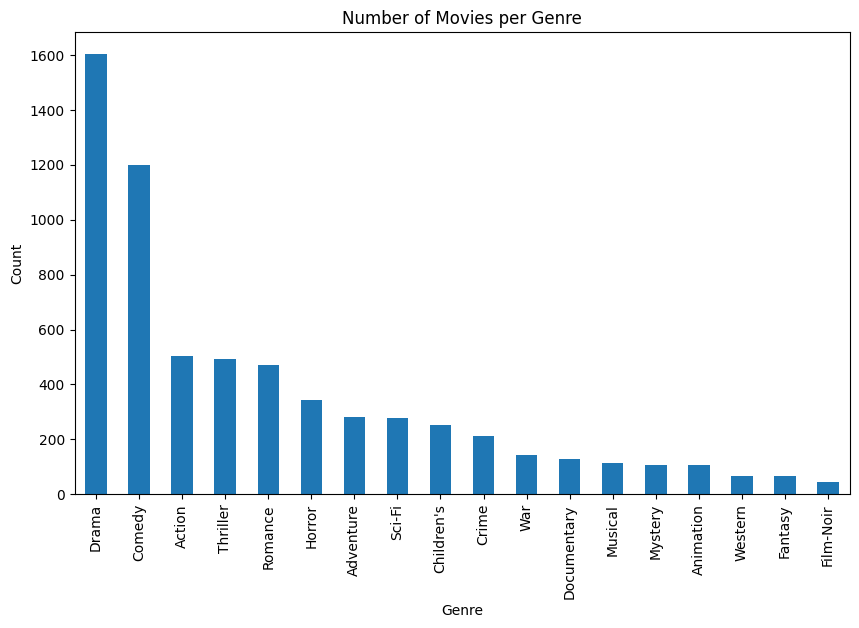

In [17]:
movies['Genres'] = movies['Genres'].str.split('|')
genres_list = sorted(set([genre for sublist in movies['Genres'] for genre in sublist]))

# Count occurrences of each genre
genre_counts = {genre: 0 for genre in genres_list}
for genres in movies['Genres']:
    for genre in genres:
        genre_counts[genre] += 1

# Convert to DataFrame
genre_counts_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
genre_counts_df.set_index('Genre')['Count'].plot(kind='bar')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


In [18]:
num_users = ratings['UserID'].nunique()
num_movies = ratings['MovieID'].nunique()
num_interactions = ratings.shape[0]

sparsity = 1 - (num_interactions / (num_users * num_movies))
print(f"Sparsity of the User-Item Interaction Matrix: {sparsity:.4f}")


Sparsity of the User-Item Interaction Matrix: 0.9553


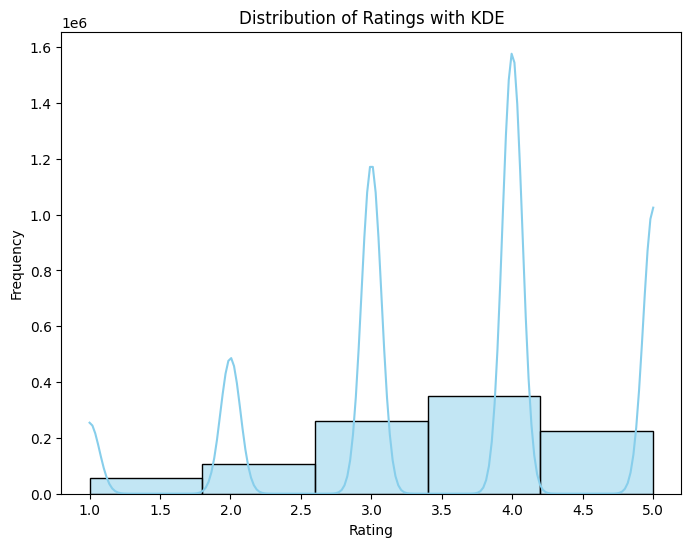

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.histplot(ratings['Rating'], kde=True, bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings with KDE')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


C:\Users\shiva\AppData\Local\Temp\ipykernel_5516\1460895949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movie_titles, palette='viridis')


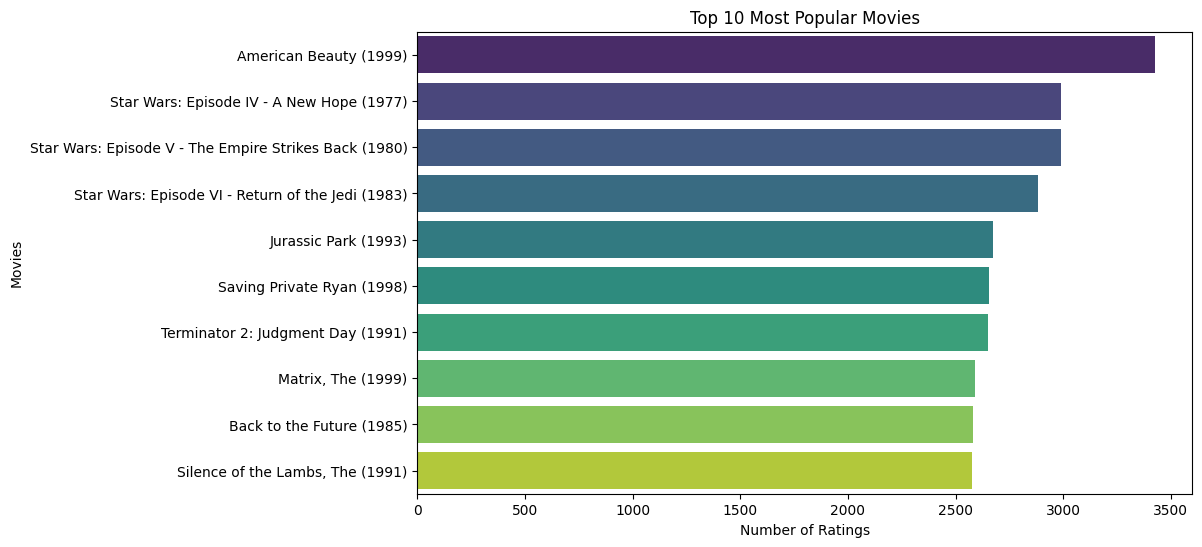

In [22]:
top_movies = ratings['MovieID'].value_counts().head(10)
top_movie_titles = movies.set_index('MovieID').loc[top_movies.index]['Title']

plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies.values, y=top_movie_titles, palette='viridis')
plt.title('Top 10 Most Popular Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.show()


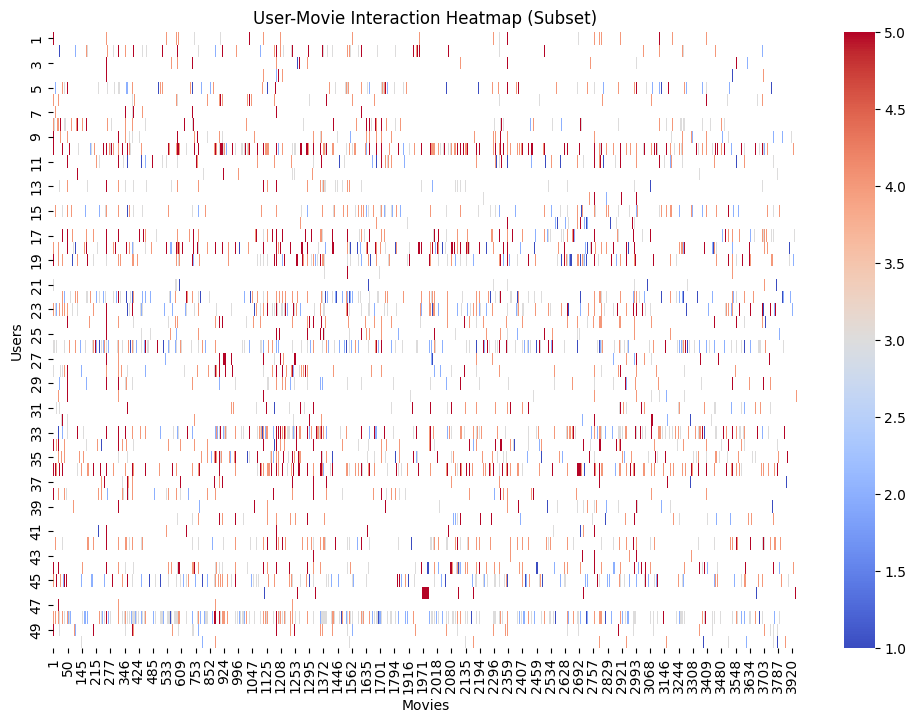

In [23]:
subset = ratings[ratings['UserID'] <= 50]  # Use a small subset for better visualization
interaction_matrix = subset.pivot(index='UserID', columns='MovieID', values='Rating')

plt.figure(figsize=(12, 8))
sns.heatmap(interaction_matrix, cmap='coolwarm', cbar=True)
plt.title('User-Movie Interaction Heatmap (Subset)')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()


In [24]:
# Average ratings and number of ratings per movie
movie_stats = ratings.groupby('MovieID').agg(
    avg_rating=('Rating', 'mean'),
    num_ratings=('Rating', 'count')
).reset_index()

# Merge with movie genres
movie_stats = movie_stats.merge(movies, on='MovieID')

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_stats, x='num_ratings', y='avg_rating', hue='Genres', alpha=0.7)
plt.title('Number of Ratings vs. Average Rating by Genre')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


TypeError: unhashable type: 'list'

<Figure size 1000x600 with 0 Axes>

C:\Users\shiva\AppData\Local\Temp\ipykernel_5516\2916774763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ratings_users, x='Gender', y='Rating', palette='Set2')


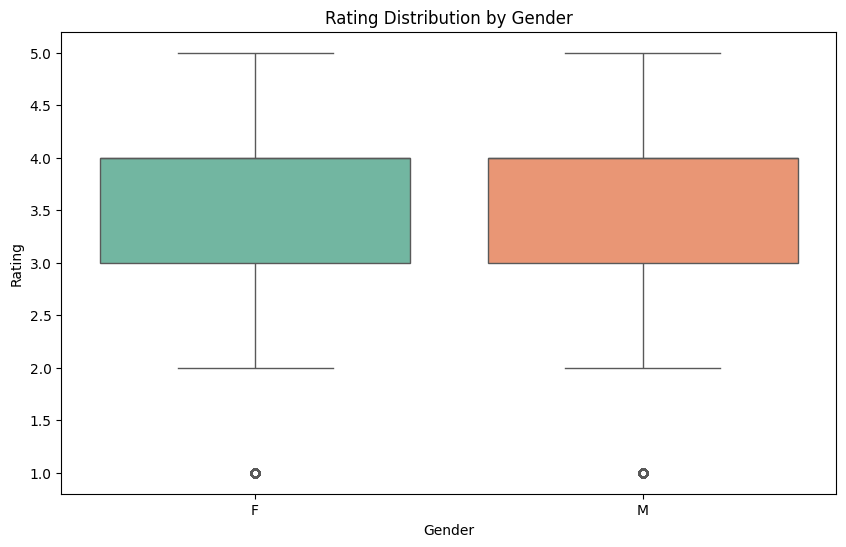

In [25]:
# Merge ratings with users
ratings_users = ratings.merge(users, on='UserID')

plt.figure(figsize=(10, 6))
sns.boxplot(data=ratings_users, x='Gender', y='Rating', palette='Set2')
plt.title('Rating Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Rating')
plt.show()


In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(users.drop(columns=['Zip-code']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for User Features')
plt.show()


ValueError: could not convert string to float: 'F'

<Figure size 800x600 with 0 Axes>

In [ ]:
import squarify

# Count occurrences of each genre
movies['Genres'] = movies['Genres'].str.split('|')
genre_counts = pd.Series([genre for sublist in movies['Genres'] for genre in sublist]).value_counts()

# Treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=genre_counts.values, label=genre_counts.index, alpha=0.8)
plt.title('Popularity of Genres (Treemap)')
plt.axis('off')
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert user-item matrix to NumPy array
R = user_item_matrix.values

# Normalize ratings
R_mean = np.mean(R, axis=1, keepdims=True)
R_normalized = R - R_mean

# Convert to PyTorch tensors
train_data = torch.FloatTensor(R_normalized)


NameError: name 'user_item_matrix' is not defined